In [ ]:
import ee
import geemap
import numpy
import requests
import io
import numpy as np
import geopandas as gpd
import random
from shapely.geometry import Point
import pickle
from PIL import Image
import os
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
from torchvision import transforms
import torch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
# prompt: mount gdrive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='ee-isekalala')

In [ ]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('hf')

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from torchvision.models import ResNet50_Weights

# Define your custom model architecture (ensure this matches what you used during training)
# Define model
def get_modified_resnet50(num_channels=12):
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    # Modify the first convolution layer
    original_conv = model.conv1
    model.conv1 = nn.Conv2d(
        num_channels,
        original_conv.out_channels,
        kernel_size=original_conv.kernel_size,
        stride=original_conv.stride,
        padding=original_conv.padding,
        bias=original_conv.bias
    )
    # Initialize the new conv layer
    nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

    # Modify the final fully connected layer for regression
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)  # Assuming single regression output

    return model

# Function to load the model from Hugging Face Hub
def load_model_from_hf(repo_id: str, filename: str = "model.safetensors", device: str = "cuda"):
    """
    Downloads the model weights from Hugging Face Hub and loads them into the architecture.

    Args:
        repo_id (str): The repository ID on the Hugging Face Hub (e.g., "your-org/your-model-repo").
        filename (str): The name of the file containing the model weights. Defaults to "pytorch_model.bin".
        device (str): The device to load the model onto ('cuda' or 'cpu').

    Returns:
        model: The model loaded with weights and set to evaluation mode.
    """
    # Download the model weights file from the Hub
    model_path = hf_hub_download(repo_id=repo_id, filename=filename)
    print(f"Downloaded model weights from: {model_path}")

    # Reconstruct the model architecture
    model = get_modified_resnet50(num_channels=12)

    # Load the state dict (weights)
    state_dict = load_file(model_path, device=device)  # <-- Changed this line
    model.load_state_dict(state_dict)

    # Move the model to the desired device and set to evaluation mode
    model.to(device)
    model.eval()

    return model

# Example usage:
if __name__ == "__main__":
    # Replace with your repository ID (e.g., "your-org/your-model-repo")
    repo_id = "Sunbird/GIZ-building-regression-model"

    # Determine device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the model from the Hugging Face Hub
    model = load_model_from_hf(repo_id=repo_id, device=device)

    # Create a dummy input tensor with the shape your model expects:
    # For example: batch size 1, 12 channels, 224x224 image.
    dummy_input = torch.randn(1, 12, 200, 200).to(device)

    # Run the model on the dummy input
    with torch.no_grad():
        output = model(dummy_input)

    print("Model output:", output)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/94.4M [00:00<?, ?B/s]

Downloaded model weights from: /root/.cache/huggingface/hub/models--Sunbird--GIZ-building-regression-model/snapshots/7df45b279e3816b773bee7de2013079db03eccbf/model.safetensors


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.9MB/s]


Model output: tensor([[0.0333]])


In [ ]:
def ee_bytes_to_img(pixel_data, num_channels):
  img = np.array([[float(x) for x in pixel] for pixel in pixel_data.ravel()])
  img = img.reshape(pixel_data.shape[0], pixel_data.shape[1], num_channels)
  return img

def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

def get_sentinel_2_pixels(region, year, scale_m=10):
  yr = str(year)
  sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
              .map(mask_s2_clouds) \
              .median()

  url = sentinel2.getDownloadUrl({
    'bands': ['B4', 'B3', 'B2'], #red, green, blue bands respectively
    'region': region,
    'scale': scale_m,
    'format': 'NPY'})
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  img = ee_bytes_to_img(data, 3)
  return np.clip(img, 0, 1)

In [ ]:
def get_composite_data(region, year, scale_m=1):
    # Sentinel-2 composite (e.g., for year-1)
    s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
          .filterBounds(region) \
          .filterDate(f'{year-1}-01-01', f'{year-1}-12-31') \
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
          .map(mask_s2_clouds) \
          .median() \
          .select(['B4', 'B3', 'B2']).unitScale(0, 1)  # 3 bands

    # We want to predict for 2025, OB goes up until 2023, so we take the Open Buildings composites for three previous years -1
    ob_y2 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-2}-01-01', f'{year-1}-12-31').mosaic()
    ob_y3 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-3}-01-01', f'{year-2}-12-31').mosaic()
    ob_y4 = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
             .filterBounds(region).filterDate(f'{year-4}-01-01', f'{year-3}-12-31').mosaic()

    # Compute building count differences directly on server side.
    # Note: Adjust the reducer and multiplication factor as needed.
    count_y2 = ob_y2.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection(), maxPixels=824814450) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y3 = ob_y3.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection(), maxPixels=824814450) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y4 = ob_y4.reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection(), maxPixels=824814450) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    diff1 = count_y2.subtract(count_y3)
    diff1_img = ee.Image.constant(diff1).rename('diff1')
    diff2 = count_y3.subtract(count_y4)
    diff2_img = ee.Image.constant(diff2).rename('diff2')

    # Dynamic World composite
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
         .filterBounds(region).filterDate(f'{year-1}-01-01', f'{year-1}-12-31') \
         .median() \
         .select(['built', 'crops', 'water', 'trees', 'grass'])  # 5 bands

    # target
    """imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1').filterBounds(region)
    count_y0 = imageCollection.filterDate(f'{year}-01-01', f'{year}-12-31').mosaic() \
                .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
                .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    count_y1 = imageCollection.filterDate(f'{year-1}-01-01', f'{year-1}-12-3').mosaic() \
                .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection()) \
                .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
    diff = count_y0.subtract(count_y1)
    target_img = ee.Image.constant(diff).rename('target')"""


    # Combine all into a single multi-band image
    composite = s2.addBands(ob_y2.select(['building_presence']).clamp(0, 1)) \
                  .addBands(ob_y3.select(['building_presence']).clamp(0, 1)) \
                  .addBands(diff1_img) \
                  .addBands(diff2_img) \
                  .addBands(dw) \
                  #.addBands(target_img)

    return composite

In [ ]:
def get_reg_target(region, year, scale_m):
  imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1').filterBounds(region)
  count_y0 = imageCollection.filterDate(f'{year}-01-01', f'{year}-12-31').mosaic() \
              .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection(), maxPixels=824814450) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
  count_y1 = imageCollection.filterDate(f'{year-1}-01-01', f'{year-1}-12-3').mosaic() \
              .reduceRegion(ee.Reducer.sum(), region, scale_m, crs= region.projection(), maxPixels=824814450) \
              .getNumber('building_fractional_count').multiply(ee.Number(scale_m * 2).pow(2))
  diff = count_y0.subtract(count_y1)
  return diff.getInfo()

In [ ]:
from shapely.geometry import Polygon, Point
import numpy as np
from functools import partial
import pyproj
from shapely.ops import transform

def sample_points_in_polygon_shapely(polygon, spacing=200):
    """
    Samples a uniform grid of points inside the input shapely polygon,
    spaced `spacing` meters apart. The polygon is assumed to be in EPSG:4326.

    Args:
        polygon (shapely.geometry.Polygon): Input polygon in geographic coordinates (EPSG:4326).
        spacing (float): The spacing between points in meters (default: 200).

    Returns:
        list: A list of (lon, lat) tuples representing the coordinates of points inside the polygon.
    """
    # Define the source CRS (WGS84)
    crs_wgs84 = pyproj.CRS("EPSG:4326")

    # Determine an appropriate UTM zone based on the polygon centroid
    centroid = polygon.centroid
    utm_zone = int((centroid.x + 180) / 6) + 1
    # Use a UTM CRS; note: adjust "+south" if in the southern hemisphere
    utm_crs = pyproj.CRS(f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs")

    # Define transformation functions
    project_to_utm = partial(pyproj.Transformer.from_crs(crs_wgs84, utm_crs, always_xy=True).transform)
    project_to_wgs84 = partial(pyproj.Transformer.from_crs(utm_crs, crs_wgs84, always_xy=True).transform)

    # Project the polygon to UTM (meters)
    polygon_utm = transform(project_to_utm, polygon)

    # Get the bounding box of the projected polygon
    minx, miny, maxx, maxy = polygon_utm.bounds
    points = []

    # Create a grid of candidate points spaced by the specified distance (in meters)
    x_coords = np.arange(minx, maxx + spacing, spacing)
    y_coords = np.arange(miny, maxy + spacing, spacing)

    for x in x_coords:
        for y in y_coords:
            p = Point(x, y)
            if polygon_utm.contains(p):
                # Transform the point back to geographic coordinates (lon, lat)
                p_wgs84 = transform(project_to_wgs84, p)
                points.append((p_wgs84.x, p_wgs84.y))

    return points

# Example usage:
if __name__ == "__main__":
    # Example polygon in EPSG:4326 (replace with your actual polygon geometry)
    sample_polygon = Polygon([
        (33.0218, 3.80975),
        (33.02515, 3.80975),
        (33.02515, 3.812),
        (33.0218, 3.812),
        (33.0218, 3.80975)
    ])

    sampled_points = sample_points_in_polygon_shapely(sample_polygon, spacing=200)
    print("Sampled Points:")
    for pt in sampled_points:
        print(pt)

Sampled Points:
(33.023601296037896, 3.8115593347010615)


In [ ]:
def get_open_buildings_pixels(region, year, scale_m=10):
  yr = str(year)
  buildings = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .first()
  url = buildings.getDownloadUrl({
    'bands': ['building_presence'],
    'region': region,
    'scale': scale_m,
    'format': 'NPY'
  })
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  img = ee_bytes_to_img(data, 1)
  return np.clip(img, 0, 1)

In [ ]:
def get_open_buildings_counts(region, year, scale_m=1):
  imageCollection = ee.ImageCollection('GOOGLE/Research/open-buildings-temporal/v1')
  yr = str(year)
  mosaic = imageCollection.filterBounds(region).filterDate(yr + '-01-01', yr + '-12-31').mosaic()

  #epoch_s = ee.Date(ee.String(yr + '-06-30'), 'America/Los_Angeles').millis().divide(1000)
  #mosaic = imageCollection.filter(ee.Filter.eq('inference_time_epoch_s', epoch_s)).mosaic()
  count = mosaic.reduceRegion(ee.Reducer.sum(), region, scale_m, crs=region.projection(), maxPixels=824814450) \
          .getNumber('building_fractional_count') \
          .multiply(ee.Number(scale_m * 2).pow(2))
          # Since the pyramiding policy is mean, we need to multiply by
          # (scale_m * 2) ** 2 to recover sum at original 50cm resolution.
  return count.getInfo()

In [ ]:
def get_dw_pixels(region, year, scale_m=10):
  yr = str(year)
  buildings = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
              .filterBounds(region) \
              .filterDate(yr + '-01-01', yr + '-12-31') \
              .median()
  url = buildings.getDownloadUrl({
    'bands': ['built', 'crops', 'water', 'trees', 'grass'],
    'region': region,
    'scale': scale_m,
    'format': 'NPY'
  })
  response = requests.get(url)
  data = numpy.load(io.BytesIO(response.content), allow_pickle=True)
  return ee_bytes_to_img(data, 5)

In [ ]:
villages_dir = '/content/drive/Shareddrives/Sunbird AI/Projects/GIZ Mini-grid Identification/Phase II/Data/administrative areas/Lamwo_villages_2020.gpkg'

In [ ]:
village_gdf = gpd.read_file(villages_dir)

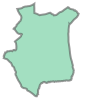

In [ ]:
# prompt: find the row with Apyetta South in addr_vname of village_gdf

# Find the row with 'Apyetta South' in 'addr_vname'
apyetta_south_row = village_gdf[village_gdf['addr_vname'] == 'Apyetta South']

# Print the row (or handle it as needed)
apyetta_south_row.geometry.iloc[0]

In [ ]:
# Assume `gdf` is your GeoDataFrame and `index` is the row you want to convert
index = 0  # Adjust the index to the specific row you want
geometry = village_gdf.iloc[index].geometry

def geom_to_ee_fmt(geometry):
  # Convert the geometry to a GeoJSON format
  geometry_geojson = geometry.__geo_interface__

# Ensure it is in the format expected by ee.Geometry.MultiPolygon
  if geometry_geojson["type"] == "MultiPolygon":
    # Create an ee.Geometry.MultiPolygon
    ee_geometry = ee.Geometry.MultiPolygon(geometry_geojson["coordinates"])
  elif geometry_geojson["type"] == "Polygon":
    # If it's a single Polygon, convert it to MultiPolygon
    ee_geometry = ee.Geometry.MultiPolygon([geometry_geojson["coordinates"]])
  else:
    raise ValueError("Geometry type is not Polygon or MultiPolygon.")
  return ee_geometry


# ee_geometry is now an Earth Engine MultiPolygon geometry
village = geom_to_ee_fmt(geometry)
print(village.getInfo())

{'type': 'Polygon', 'coordinates': [[[33.021795932856996, 3.8097489636418054], [33.0214095313367, 3.806644512528437], [33.02301920233525, 3.8062564133735934], [33.02485427551908, 3.8075498874955143], [33.02623122133802, 3.8084275816661677], [33.025151252073, 3.809956278325074], [33.021795932856996, 3.8097489636418054]]]}


In [ ]:
# prompt: get the geometry of the first row from village_gdf

points = sample_points_in_polygon_shapely(apyetta_south_row.geometry.iloc[0], spacing=200)

In [ ]:
len(points)

2230

In [ ]:
pred = 0
targets = 0
model.eval()
# Use ThreadPoolExecutor to parallelize the processing of points
with ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(lambda point: process_point(point[1], point[0], 2023), points)

Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value


Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value
Error processing point: cannot access local variable 'pred' where it is not associated with a value


In [ ]:
targets

571.8397057565046

In [ ]:
pred

87.81791567988694

In [ ]:
lamw_dec = 3.6178832, 32.6510669 #an area in Lamwo with decrease in buildings
kyam = 0.34391170612047717, 32.63150537494272 # area in kyambogo
numu = 0.7124211360209369, 32.783651340130085 #namuganga
lake = -0.08423319553560636, 32.96628528341806 #over the lake

lat, lng = kyam

In [ ]:
"""buffer_distance = 100
point = ee.Geometry.Point([lng, lat])"""
region = geom_to_ee_fmt(apyetta_south_row.geometry.iloc[0])
scale_m = 1

print("building counts for year 2023: ", get_open_buildings_counts(region, 2023))
print("building counts for year 2022: ", get_open_buildings_counts(region, 2022))

building counts for year 2023:  5036.126159301598
building counts for year 2022:  3874.2813599126057


In [ ]:
composite = get_composite_data(region, 2023, 50)
url = composite.getDownloadUrl({
    'bands': ['B4', 'B3', 'B2', 'building_presence', 'building_presence_1', 'diff1', 'diff2', 'built', 'crops', 'water', 'trees', 'grass'],
    'region': region,
    'scale': 50,
    'format': 'NPY'
})
response = requests.get(url)
data = np.load(io.BytesIO(response.content), allow_pickle=True)
resized = ee_bytes_to_img(data, 12)


In [ ]:
resized.shape

(274, 221, 12)

In [ ]:
pred = 0
with torch.no_grad():
  pred = model(torch.tensor(resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device))
print(pred)

tensor([[70.7000]])


In [ ]:
#Precalculated means and stds for Normalization
mean = torch.Tensor([0.1217270940542221, 0.11625519394874573, 0.11000549048185349, 0.011712568812072277, 0.011117534711956978, 0.6160487532615662, 0.5525528192520142, 0.1383216381072998, 0.1876230090856552, 0.07891623675823212, 0.30977097153663635, 0.1511278599500656])
std = torch.Tensor([0.05446215718984604, 0.03039601258933544, 0.03132794052362442, 0.07931023091077805, 0.07740972191095352, 0.04288787022233009, 0.05698736011981964, 0.21387967467308044, 0.14159177243709564, 0.17825061082839966, 0.2660183608531952, 0.13877056539058685])

def rescale_to_8bit(image_data, mins, maxs):
    # Compute the range for each channel
    diffs = maxs - mins

    # Apply scaling per channel. Assumes image_data has shape (..., channels)
    scaled_data = 255 * (image_data - mins) / diffs

    # Clip values to ensure they lie between 0 and 255, then convert to uint8
    scaled_data = np.clip(scaled_data, 0, 255)
    return scaled_data.astype(np.uint8)

#global mins and maxs arrays for your 12 channels:
mins = np.array([0.029999999329447746, 0.04580000042915344, 0.0625,
                 0.0, 0.0, -28.30534877019631, -18.59455935598352,
                 0.0, 0.0, 0.0, 0.0, 0.0])
maxs = np.array([0.43389999, 0.45219999, 0.37320001,
                 1.0, 1.0, 17.798385901933557, 15.45278815641693,
                 0.7826327021463167, 0.650800557781919, 0.7522232439733658,
                 0.7768183690705743, 0.7064678945463211])

In [ ]:
# prompt: convert inp to tensor, and input to the model

# Convert the NumPy array 'inp' to a PyTorch tensor

#rescaled = rescale_to_8bit(inp, mins, maxs)
inp_tensor = torch.tensor(inp, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
#normalized = transforms.functional.normalize(inp_tensor, mean, std)

# Make sure the model is in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(inp_tensor)

print("Model output:", output)
print("Real target:", target)

Model output: tensor([[0.0459]])
Real target: 0


In [ ]:
inp_tensor.shape

torch.Size([1, 12, 200, 200])

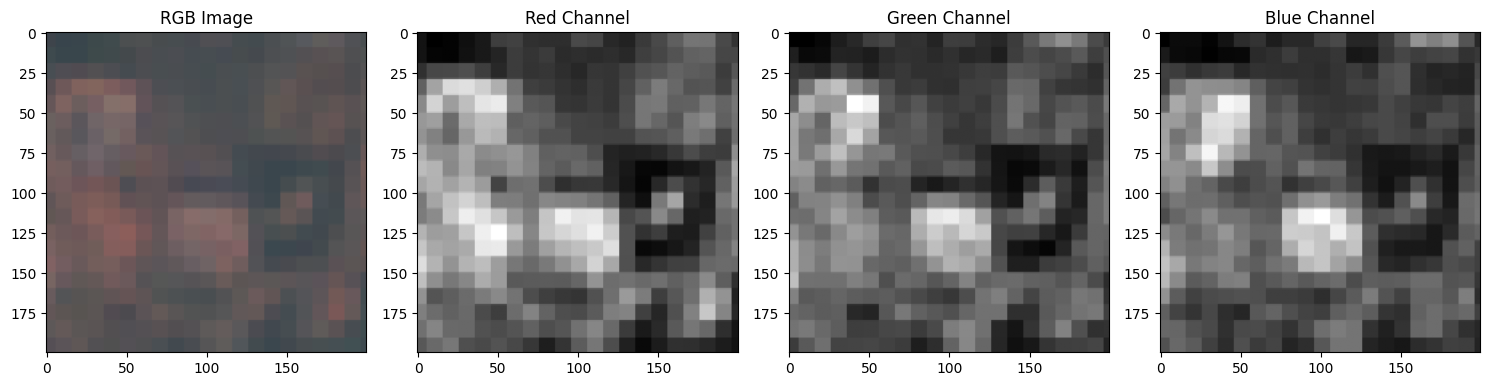

In [ ]:
# prompt: i want to visualize the first three channels of my input, which is in the rgb bands. i also want to visualize the fourth, which is a single band, help me do this with im subplots

import matplotlib.pyplot as plt

# Assuming 'inp' is your input data with shape (height, width, 12)
# and the first three channels are RGB, and the fourth is a single band.

# Extract RGB channels
rgb_image = inp[:, :, :3]

# Extract the fourth channel (single band)
band4_image = inp[:, :, 3]
year1_count = inp[:, :, 4][0][0]
band5_image = inp[:, :, 5]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 4 columns

# Display RGB image
axes[0].imshow(rgb_image * 3)
axes[0].set_title("RGB Image")

# Display individual RGB channels
axes[1].imshow(rgb_image[:, :, 0], cmap='gray')
axes[1].set_title("Red Channel")
axes[2].imshow(rgb_image[:, :, 1], cmap='gray')
axes[2].set_title("Green Channel")
axes[3].imshow(rgb_image[:, :, 2], cmap='gray')
axes[3].set_title("Blue Channel")

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()


Text(0.5, 1.0, 'year - 3')

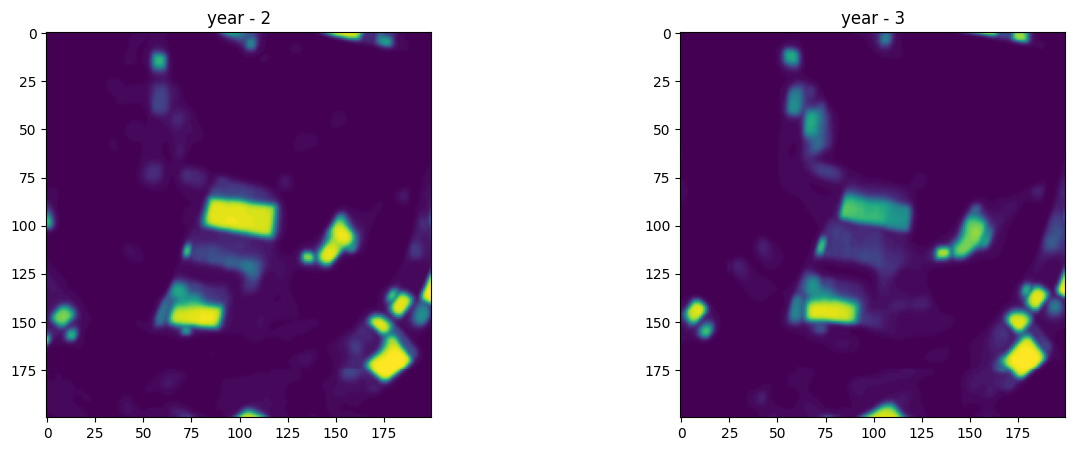

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 4 columns

#Display the fourth band
axes[0].imshow(band4_image)  # Use a grayscale colormap
axes[0].set_title("year - 2")
#display the fifth band
axes[1].imshow(band5_image)  # Use a grayscale colormap
axes[1].set_title("year - 3")